In [1]:
import xarray as xr
import torch
from torch.utils.data import DataLoader
from xbatcher import BatchGenerator

import matplotlib.pyplot as plt
from utils.general import load_config

config = load_config()

In [2]:
config

{'model': {'architecture': 'SRResNet',
  'large_kernel_size': 9,
  'small_kernel_size': 3,
  'n_channels': 64,
  'n_blocks': 16,
  'scaling_factor': 8},
 'training': {'streaming': False,
  'learning_rate': 0.01,
  'batch_size': 32,
  'epochs': 100,
  'optimizer': 'Adam',
  'loss_function': 'mse_loss',
  'devices': [0],
  'accelerator': 'gpu',
  'deterministic': True,
  'seed': 42},
 'dataset': {'hr_zarr_url': 'https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr',
  'lr_zarr_url': 'https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr',
  'time_range': '2024-10',
  'start_date': '2020-01-01',
  'end_date': '2020-01-10',
  'latitude_range': [35.0, 71.0],
  'longitude_range': [-25.0, 40.0],
  'data_variable': ['t2m'],
  'data_target': ['t2m'],
  'unit': 'Temperature (C)'},
 'validation': {'val_split_ratio': 0.3},
 'checkpoint': {'monitor': 'val_ssim',
  'mode': 'max',
  'filename': 'best-val-ssim-{

In [3]:

start_date = config['dataset']['start_date']
end_date = config['dataset']['end_date']
data_vars = config['dataset']['data_variable']
data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})


latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
data = data.sel(time=slice(start_date, end_date))
data = data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                time=slice(start_date,end_date))

In [17]:
# data_vars = list(data.data_vars)

data = data[data_vars]
data.sizes

Frozen({'time': 24, 'latitude': 819, 'longitude': 1479})

In [5]:
data.sizes['latitude']

819

In [6]:
GPU_DEVICE = 0
device = torch.device("cuda",GPU_DEVICE)
batch_generator = BatchGenerator(data, input_dims={"time": config['training']['batch_size'],
                                                   "latitude":  data.sizes['latitude'],
                                                   "longitude": data.sizes['longitude']})

In [7]:
# Iterate through one batch
for batch in batch_generator:

    data  = batch.load()
    print(data.sizes)
    data = data.to_array().values
    data = torch.tensor(data)
    data = torch.permute(data, (1, 0, 2, 3))
    print(data.shape)
    data.to(device)
    break

Frozen({'time': 32, 'latitude': 819, 'longitude': 1479})
torch.Size([32, 1, 819, 1479])


## Benchmark

In [8]:
import xarray as xr
import time
import numpy as np
from xbatcher import BatchGenerator
from utils.general import load_config

config = load_config()

In [19]:
import time
import numpy as np
import xarray as xr

num_trials = 10  # Number of repetitions
batch = 8

# Open dataset once
data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={}
)
data = data.sel(
    time=slice("2025-03-01", "2025-03-01"),
    latitude=slice(*config["dataset"]["latitude_range"]),
    longitude=slice(*config["dataset"]["longitude_range"])
)

data_vars = list(data.data_vars)  # List of available variables

num_vars_list = []
time_avg_list = []
time_std_list = []
size_data = []

for num_vars in range(1, min(len(data_vars), 10)):  # Avoid index error
    selected_vars = data_vars[:num_vars]  # Select `num_vars` variables
    hr_data_subset = data[selected_vars]
    print(selected_vars)

    batch_generator_hr = BatchGenerator(hr_data_subset, input_dims={
        "time": batch,
        "latitude": hr_data_subset.sizes["latitude"],
        "longitude": hr_data_subset.sizes["longitude"]
    })

    times = []

    for _ in range(num_trials):  # Run multiple trials
        start_time = time.time()

        for batch_data in batch_generator_hr:
            data_batch = batch_data.load()

        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        size = data_batch.nbytes / (1024 * 1024)  # Size in MB
    print(data_batch.sizes)
    avg_time = np.mean(times)
    std_time = np.std(times)

    num_vars_list.append(num_vars)
    time_avg_list.append(avg_time)
    time_std_list.append(std_time)
    size_data.append(size)

    print(f"Num Vars: {num_vars}, Avg Time: {avg_time:.4f} sec, Std Dev: {std_time:.4f} sec")


['blh']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 1, Avg Time: 4.2866 sec, Std Dev: 0.3584 sec
['blh', 'chnk']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 2, Avg Time: 7.0937 sec, Std Dev: 0.6212 sec
['blh', 'chnk', 'd2m']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 3, Avg Time: 9.4700 sec, Std Dev: 0.4238 sec
['blh', 'chnk', 'd2m', 'e']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 4, Avg Time: 13.6715 sec, Std Dev: 0.9618 sec
['blh', 'chnk', 'd2m', 'e', 'ewss']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 5, Avg Time: 17.1056 sec, Std Dev: 0.5566 sec
['blh', 'chnk', 'd2m', 'e', 'ewss', 'hcc']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 6, Avg Time: 19.9192 sec, Std Dev: 0.7452 sec
['blh', 'chnk', 'd2m', 'e', 'ewss', 'hcc', 'lcc']
Frozen({'time': 8, 'latitude': 819, 'longitude': 1479})
Num Vars: 7, Avg Time: 22.6155 sec, Std Dev: 0.5510 sec
['blh', 'chnk',

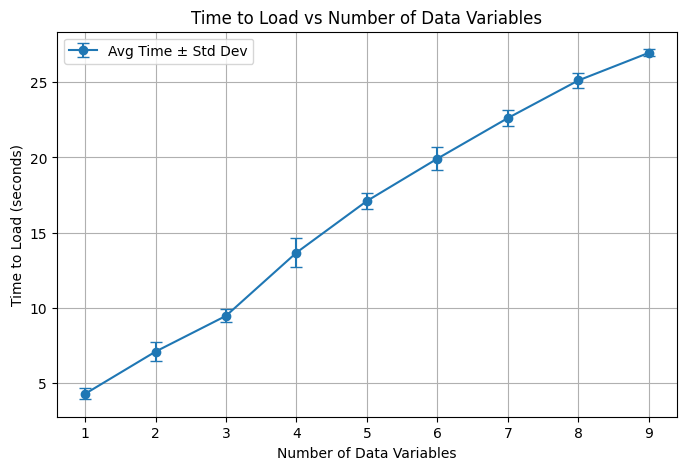

In [20]:
# Plot the results with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(num_vars_list, time_avg_list, yerr=time_std_list, fmt='-o', capsize=4, label="Avg Time ± Std Dev")
plt.xlabel("Number of Data Variables")
plt.ylabel("Time to Load (seconds)")
plt.title("Time to Load vs Number of Data Variables")
plt.grid()
plt.legend()
plt.savefig("load_vs_parameters.png")
plt.show()

In [21]:
import pandas as pd


max_bandwidth_Mbps = 25000
df = pd.DataFrame(data={"climate_variables":num_vars_list,
                        "time_avg":time_avg_list,
                        "time_std":time_std_list,
                        "size_data":size_data})

df["batch"] = 64
df["fps"] = (df['climate_variables'] *  df["batch"] / df["time_avg"])
df['bandwidth_MBps'] = df['size_data'] / df["time_avg"]
df['bandwidth_Mbps'] = df['size_data'] / df["time_avg"] * 8
df['max_bandwidth_Mbps'] = max_bandwidth_Mbps
df["max_fps"] = df['max_bandwidth_Mbps'] * df["fps"] / df['bandwidth_Mbps']
df["max_fps"] = df['max_bandwidth_Mbps'] * df["fps"] / df['bandwidth_Mbps']

In [23]:
df

,climate_variables,time_avg,time_std,size_data,batch,fps,bandwidth_MBps,bandwidth_Mbps,max_bandwidth_Mbps,max_fps
0,1,4.286621,0.358385,36.983589,64,14.930175,8.627679,69.021431,25000,5407.803961
1,2,7.093684,0.621209,73.949562,64,18.044221,10.424705,83.397640,25000,5409.092208
2,3,9.469954,0.423788,110.915535,64,20.274650,11.712363,93.698901,25000,5409.521760
3,4,13.671499,0.961809,147.881508,64,18.725087,10.816774,86.534189,25000,5409.736562
4,5,17.105572,0.556555,184.847481,64,18.707354,10.806273,86.450183,25000,5409.865451
5,6,19.919157,0.745202,221.813454,64,19.277924,11.135685,89.085477,25000,5409.951381
6,7,22.615523,0.551030,258.779427,64,19.809403,11.442558,91.540462,25000,5410.012761
7,8,25.115321,0.498952,295.745399,64,20.385963,11.775497,94.203979,25000,5410.058797
8,9,26.951331,0.241424,332.711372,64,21.371857,12.344896,98.759167,25000,5410.094603
